In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

**Data Loading**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/E-commerce Furniture Dataset 2024/ecommerce_furniture_dataset_2024.csv')

**Data Cleaning**

In [4]:
df.head()

,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


In [5]:
df.shape

(2000, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   productTitle   2000 non-null   object
 1   originalPrice  487 non-null    object
 2   price          2000 non-null   object
 3   sold           2000 non-null   int64 
 4   tagText        1997 non-null   object
dtypes: int64(1), object(4)
memory usage: 78.3+ KB


In [7]:
df.isnull().sum()

,0
productTitle,0
originalPrice,1513
price,0
sold,0
tagText,3


In [8]:
df['sold'].value_counts()

,count
sold,
0,451
1,319
2,196
3,132
4,95
...,...
369,1
275,1
280,1


In [9]:
# Define bins and labels
bins = [-1, 0, 5, 20, 50, 100, 200, 500, df['sold'].max()]
labels = ["0", "1-5", "6-20", "21-50", "51-100", "101-200", "201-500", "500+"]

# Create grouped column without overwriting 'sold'
df['sold_group'] = pd.cut(df['sold'], bins=bins, labels=labels, ordered=True)

# Count grouped sales
print(df['sold_group'].value_counts())


sold_group
1-5        821
6-20       475
0          451
21-50      167
51-100      38
101-200     22
201-500     13
500+        13
Name: count, dtype: int64


In [10]:
df['tagText'].value_counts()

,count
tagText,
Free shipping,1880
+Shipping: $5.09,9
+Shipping: $239.64,2
+Shipping: $80.21,2
+Shipping: $94.92,2
...,...
+Shipping: $134.27,1
+Shipping: $151.69,1
+Shipping: $41.93,1


In [11]:
def group_shipping(tag):
    if pd.isna(tag):
        return "Unknown"
    elif "Free shipping" in tag:
        return "Free"
    elif "Unknown" in tag:
        return "Unknown"
    elif "Shipping" in tag:
        return "Paid"
    else:
        return "Other"

df['tagText_group'] = df['tagText'].apply(group_shipping)

# Count grouped categories
print(df['tagText'].value_counts())


tagText
Free shipping         1880
+Shipping: $5.09         9
+Shipping: $239.64       2
+Shipping: $80.21        2
+Shipping: $94.92        2
                      ... 
+Shipping: $134.27       1
+Shipping: $151.69       1
+Shipping: $41.93        1
+Shipping: $78.61        1
+Shipping: $171.49       1
Name: count, Length: 100, dtype: int64


In [12]:
# Clean price columns
import re
def clean_price(x):
    if pd.isna(x):
        return np.nan
    return float(re.sub(r'[^\d.]', '', str(x)))

In [13]:
df['originalPrice'] = df['originalPrice'].apply(clean_price)
df['price'] = df['price'].apply(clean_price)

In [14]:
# Fill missing originalPrice
df['originalPrice'] = df['originalPrice'].fillna(df['price'])
df['originalPrice'] = df['originalPrice'].fillna(df['originalPrice'].median())

In [15]:
# Create discount features
df['discount'] = df['originalPrice'] - df['price']
df['discount_percent'] = np.where(df['originalPrice'] > 0,
                                  (df['discount'] / df['originalPrice']) * 100, 0)

In [16]:
# Fill missing tagText
df['tagText'] = df['tagText'].fillna("Unknown")


In [17]:
df

,productTitle,originalPrice,price,sold,tagText,sold_group,tagText_group,discount,discount_percent
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,46.79,46.79,600,Free shipping,500+,Free,0.00,0.000000
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,169.72,169.72,0,Free shipping,0,Free,0.00,0.000000
2,Desser For Bedroom With 7 Fabric Drawers Organ...,78.40,39.46,7,Free shipping,6-20,Free,38.94,49.668367
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",111.99,111.99,0,Free shipping,0,Free,0.00,0.000000
4,Small Unit Simple Computer Desk Household Wood...,48.82,21.37,1,Free shipping,1-5,Free,27.45,56.226956
...,...,...,...,...,...,...,...,...,...
1995,Modern TV Stand Entertainment Center with Two ...,72.49,72.49,8,Free shipping,6-20,Free,0.00,0.000000
1996,"Large Wardrobe Armoire Closet with 3 Doors, Fr...",276.65,276.65,2,Free shipping,1-5,Free,0.00,0.000000
1997,"Velvet Futon Sofa Bed, 73-inch Sleeper Couch w...",196.44,196.44,10,Free shipping,6-20,Free,0.00,0.000000
1998,Furniture Acrylic Coffee Table Transparent Liv...,228.18,228.18,0,Free shipping,0,Free,0.00,0.000000


**Graphs**

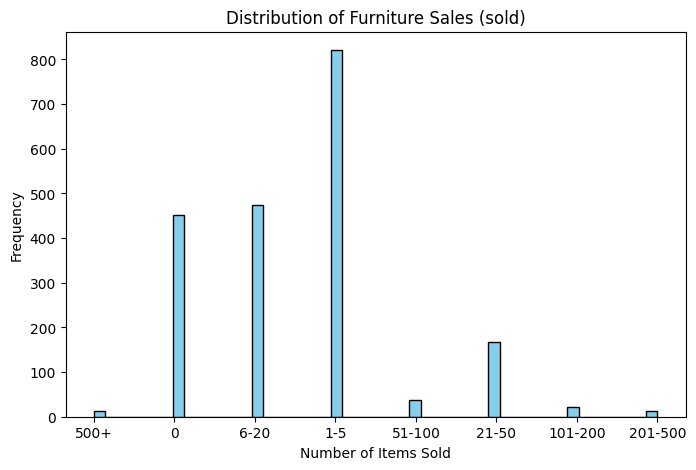

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df['sold_group'], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Furniture Sales (sold)")
plt.xlabel("Number of Items Sold")
plt.ylabel("Frequency")
plt.show()


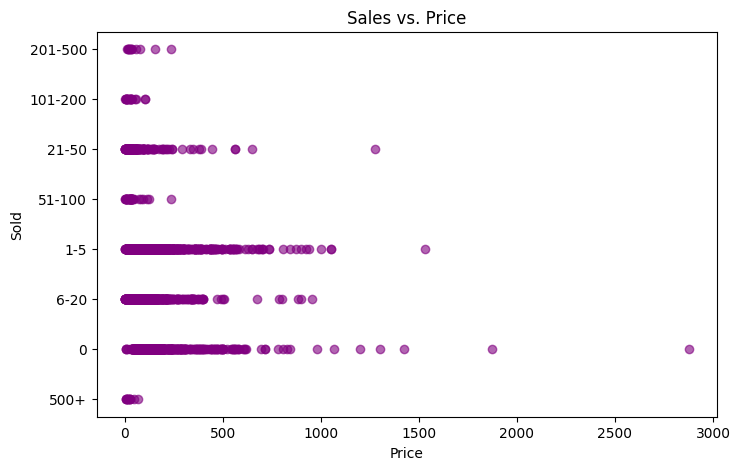

In [19]:
plt.figure(figsize=(8,5))
plt.scatter(df['price'], df['sold_group'], alpha=0.6, color="purple")
plt.title("Sales vs. Price")
plt.xlabel("Price")
plt.ylabel("Sold")
plt.show()


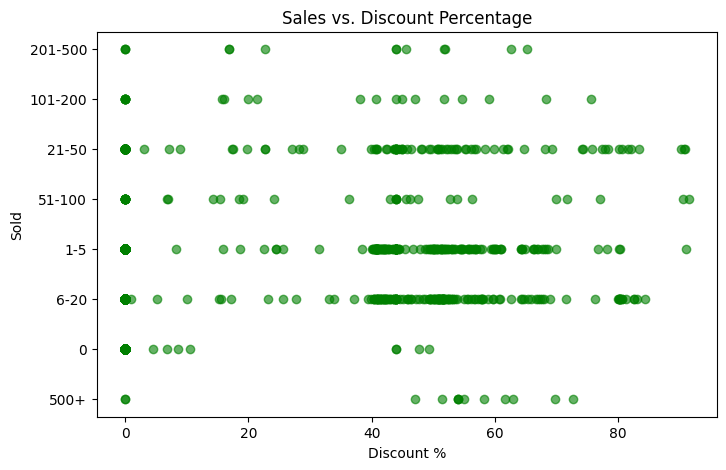

In [20]:
plt.figure(figsize=(8,5))
plt.scatter(df['discount_percent'], df['sold_group'], alpha=0.6, color="green")
plt.title("Sales vs. Discount Percentage")
plt.xlabel("Discount %")
plt.ylabel("Sold")
plt.show()


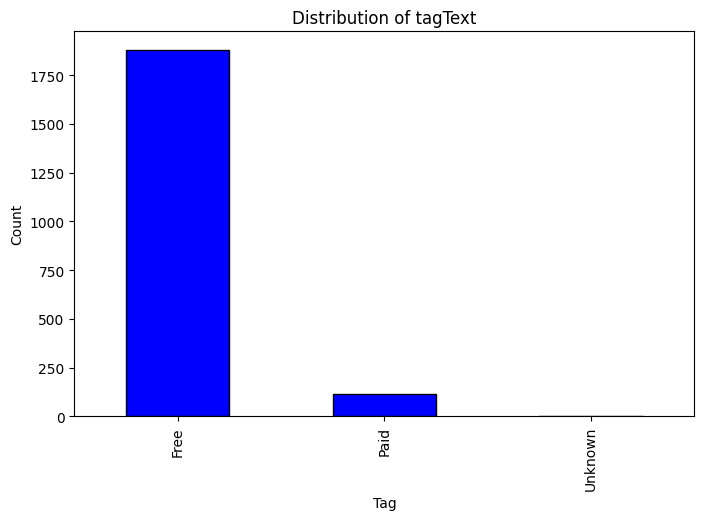

In [21]:
df['tagText_group'].value_counts().plot(kind='bar', figsize=(8,5), color="Blue", edgecolor="black")
plt.title("Distribution of tagText")
plt.xlabel("Tag")
plt.ylabel("Count")
plt.show()


/tmp/ipython-input-3813034535.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_sales = df.groupby(df['discount_group'].cat.remove_unused_categories())['sold'].mean()


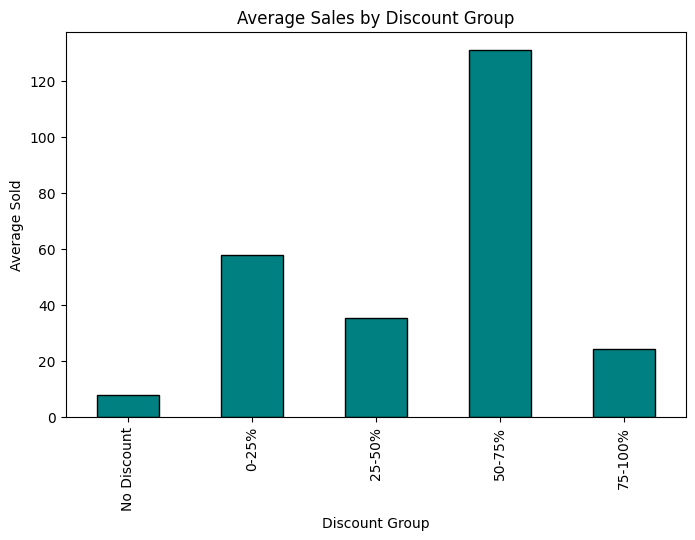

In [22]:
# Define bins and labels
bins = [-1, 0, 25, 50, 75, 100]
labels = ["No Discount", "0-25%", "25-50%", "50-75%", "75-100%"]

df['discount_group'] = pd.cut(df['discount_percent'], bins=bins, labels=labels, ordered=True)

# Compute average sales per discount group
avg_sales = df.groupby(df['discount_group'].cat.remove_unused_categories())['sold'].mean()

# Plot with correct order
avg_sales.plot(kind='bar', figsize=(8,5), color="teal", edgecolor="black")
plt.title("Average Sales by Discount Group")
plt.xlabel("Discount Group")
plt.ylabel("Average Sold")
plt.show()



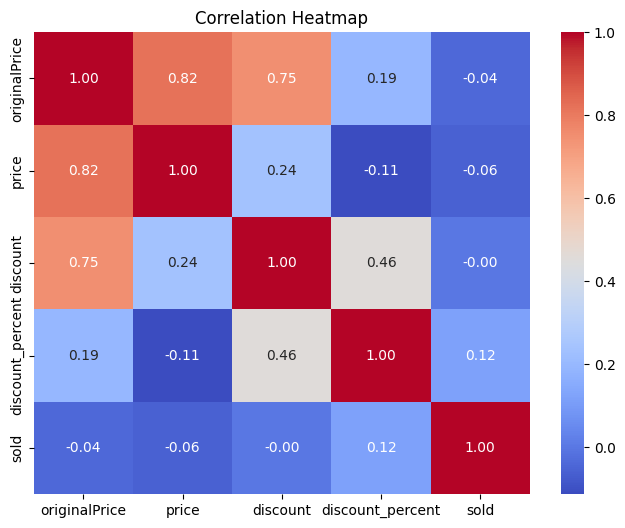

In [23]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df[['originalPrice','price','discount','discount_percent','sold']].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


**Models**

In [27]:
X = df[['productTitle', 'originalPrice', 'price', 'tagText_group', 'discount', 'discount_percent']]
y = np.log1p(df['sold'])


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('title', TfidfVectorizer(max_features=500), 'productTitle'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['tagText_group']),
        ('num', StandardScaler(), ['originalPrice', 'price', 'discount', 'discount_percent'])
    ]
)



**LinearRegression**

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Linear Regression pipeline
linear_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

linear_pipe.fit(X_train, y_train)
y_pred_log = linear_pipe.predict(X_test)



print("Linear Regression:")
print("MAE:", mean_absolute_error(y_test, y_pred_log))
print("RMSE:", np.sqrt(mean_squared_error(y_test,  y_pred_log)))
print("R²:", r2_score(y_test, y_pred_log))


Linear Regression:
MAE: 0.9549573672939085
RMSE: 1.1870446308579214
R²: 0.23902297663386407


In [44]:
X_train

,productTitle,originalPrice,price,tagText,discount,discount_percent
968,"armocity 48'' Makeup Vanity with Hutch, Modern...",187.95,187.95,Free shipping,0.00,0.000000
240,Light Luxury Makeup Stools Round Stool Chairs ...,47.73,26.76,Free shipping,20.97,43.934632
819,Auto LED Nightstand with 2 USB Charging Statio...,73.01,73.01,Free shipping,0.00,0.000000
692,"Modern furniture, simple custom furniture",1.01,1.01,Free shipping,0.00,0.000000
420,Outdoor Swing Chair Canopy Sunshade Swing Top ...,20.29,11.37,Free shipping,8.92,43.962543
...,...,...,...,...,...,...
1130,Outdoor Portable Plastic Folding Retractable B...,3.94,3.94,+Shipping: $14.97,0.00,0.000000
1294,"Sofa Bed with 2 USB, Tufted Foldable for Tight...",124.06,124.06,Free shipping,0.00,0.000000
860,"LED Dresser for Bedroom Wood, 6 Drawer with 2 ...",189.39,189.39,Free shipping,0.00,0.000000
1459,4 Door Wardrobe Armoire Closet with Mirror Doo...,467.98,467.98,Free shipping,0.00,0.000000


**RandomForestRegressor**

In [32]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest pipeline
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_pipe.fit(X_train, y_train)
y_pred_log = rf_pipe.predict(X_test)


print("Random Forest:")
print("MAE:", mean_absolute_error(y_test, y_pred_log))
print("RMSE:", np.sqrt(mean_squared_error(y_test,  y_pred_log)))
print("R²:", r2_score(y_test, y_pred_log))


Random Forest:
MAE: 0.8364158726595039
RMSE: 1.05985640235051
R²: 0.3933593569640107


**XGBRegressor**

In [33]:
from xgboost import XGBRegressor

# XGBoost pipeline
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42))
])

xgb_pipe.fit(X_train, y_train)
y_pred_log = xgb_pipe.predict(X_test)



print("XGBoost:")
print("MAE:", mean_absolute_error(y_test, y_pred_log))
print("RMSE:", np.sqrt(mean_squared_error(y_test,  y_pred_log)))
print("R²:", r2_score(y_test, y_pred_log))


XGBoost:
MAE: 0.8324195556131042
RMSE: 1.0752973031182256
R²: 0.37555446985092933
